# shp

> Spatially Homogenious Pixels Identification

In [ ]:
#| default_exp cli/shp

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from itertools import product

import zarr
import cupy as cp
import numpy as np
from matplotlib import pyplot as plt
import colorcet

from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster
from dask_cuda import LocalCUDACluster

from decorrelation.shp import ks_test
from decorrelation.cli.utils.logging import get_logger

from fastcore.script import call_parse

In [ ]:
#| export
@call_parse
def de_shp_test(rslc:str, # input: rslc stack
                pvalue:str, # output: the p value of the test
                az_half_win:int, # azimuth half window size
                r_half_win:int, # range half window size
                method:str=None, # SHP identification method,optional. Default: ks
                r_chunk_size:int=None, # range chunk size, Optional. Default: the range chunk size in rslc stack
                az_chunk_size:int=None, # azimuth chunk size, optional. Default: the azimuth chunk size in rslc stack
                log:str=None, # log file, optional. Default: no log file
               ):
    '''SHP identification through hypothetic test.'''
    rslc_path = rslc
    pvalue_path = pvalue

    logger = get_logger(logfile=log)
    if not method: method = 'ks'
    logger.info(f'hypothetic test method: {method}')
    if method != 'ks':
        logger.warning('Currently only KS test is implented. Switching to it.')
        method = 'ks'

    rslc_zarr = zarr.open(rslc_path,mode='r')
    logger.info('rslc dateset shape: '+str(rslc_zarr.shape))
    logger.info('rslc dataset chunks: '+str(rslc_zarr.chunks))

    assert rslc_zarr.ndim == 3, " rslcs dimentation is not 3."

    if not az_chunk_size:
        az_chunk_size = rslc_zarr.chunks[0]
        logger.info('using default parallel processing azimuth chunk size.')
    logger.info('parallel processing azimuth chunk size: '+str(az_chunk_size))
    if not r_chunk_size:
        r_chunk_size = rslc_zarr.chunks[1]
        logger.info('using default parallel processing range chunk size.')
    logger.info('parallel processing range chunk size: '+str(r_chunk_size))

    chunks=(az_chunk_size,r_chunk_size,rslc_zarr.shape[2])
    
    logger.info('starting dask CUDA local cluster.')
    cluster = LocalCUDACluster()
    client = Client(cluster)
    logger.info('dask local CUDA cluster started.')

    cpu_rslc = da.from_zarr(rslcs,chunks=chunks)
    logger.info('rslc dask array shape: ' + str(cpu_rslc.shape))
    logger.info('rslc dask array chunks: '+ str(cpu_rslc.chunks))

    az_win = 2*az_half_win+1
    logger.info(f'azimuth half window size: {az_half_win}; azimuth window size: {az_win}')
    r_win = 2*r_half_win+1
    logger.info(f'range half window size: {r_half_win}; range window size: {r_win}')

    depth = {0:az_half_win, 1:r_half_win, 2:0}; boundary = {0:'none',1:'none',2:'none'}
    cpu_rslc_overlap = da.overlap.overlap(cpu_rslc,depth=depth, boundary=boundary)
    logger.info('setting shared boundaries between rlsc chunks.')
    logger.info(f'rslc dask array with overlap shape: {cpu_rslc_overlap.shape}')
    logger.info(f'rslc dask array with overlap chunks: {cpu_rslc_overlap.chunks}')

    rslc_overlap = cpu_rslc_overlap.map_blocks(cp.asarray)
    rmli_overlap = da.abs(rslc_overlap)**2
    logger.info(f'rmli dask array with overlap shape: {rmli_overlap.shape}')
    logger.info(f'rmli dask array with overlap chunks: {rmli_overlap.chunks}')

    sorted_rmli_overlap = rmli_overlap.map_blocks(cp.sort,axis=-1)

    chunks_size = rmli_overlap.chunks 
    nchunks = tuple(len(nchunks_in_each_dim) for nchunks_in_each_dim in chunks_size)
    chunks_shape = list(product(*chunks_size))
    rmli_chunks = sorted_rmli_overlap.to_delayed()

    delayed_ks_test = delayed(ks_test,pure=True,nout=2)
    results = [delayed_ks_test(rmli_chunk,az_half_win=az_half_win,r_half_win=r_half_win) for rmli_chunk in rmli_chunks.ravel()]
    dist_chunks, p_chunks = zip(*results)
    dist_chunks, p_chunks = np.array(dist_chunks), np.array(p_chunks)
    logger.info('applying test on sorted rmli stack.')

    for i in range(len(chunks_shape)):
        # dist_chunks[i] = da.from_delayed(dist_chunks[i],shape=(*chunks_shape[i][:-1],az_win,r_win),meta=cp.array((),dtype=rmli_overlap.dtype))
        p_chunks[i] = da.from_delayed(p_chunks[i],shape=(*chunks_shape[i][:-1],az_win,r_win),meta=cp.array((),dtype=rmli_overlap.dtype))

    # dist_chunks = dist_chunks.reshape((*nchunks,1)).tolist()
    p_chunks = p_chunks.reshape((*nchunks,1)).tolist()
    # dist = da.block(dist_chunks)
    p = da.block(p_chunks)
    logger.info('p value generated')
    logger.info(f'p value shape: {p.shape}')
    logger.info(f'p value chunks: {p.chunks}')

    depth = {0:az_half_win, 1:r_half_win, 2:0, 3:0}; boundary = {0:'none',1:'none',2:'none',3:'none'}
    # dist = da.overlap.trim_overlap(dist,depth=depth,boundary=boundary)
    p = da.overlap.trim_overlap(p,depth=depth,boundary=boundary)
    logger.info('trim shared boundaries between p value chunks')
    logger.info(f'trimmed p value shape: {p.shape}')
    logger.info(f'trimmed p value chunks: {p.chunks}')

    # cpu_dist = da.map_blocks(cp.asnumpy,dist)
    cpu_p = da.map_blocks(cp.asnumpy,p)
    
    # _cpu_dist = cpu_dist.to_zarr(statistic,overwrite=True,compute=False)
    _cpu_p = cpu_p.to_zarr(pvalue_path,overwrite=True,compute=False)
    logger.info('saving p value.')
    logger.info('computing graph setted. doing all the computing.')
    da.compute(_cpu_p)
    logger.info('computing finished.')
    cluster.close()
    logger.info('dask cluster closed.')

This function is a wrapper of functions in `decorrelation.shp` that provides file interface. Please refer it for the usage. It utilizes dask for parallel and distributed computation. Compared with the functions in `decorrelation.shp`, this function splits the dataset into several chunks and the computation in these chunks can run in parallel on multi-GPUs.

The `r_chunk_size` and `az_chunk_size` is used to determine how many pixels in range and azimuth in one chunk. The chunk size of the output pvalue is also setted according to them.

In [ ]:
rslcs = '../../data/rslc.zarr'
pvalue = './pvalue.zarr'
az_half_win = 5
r_half_win = 5
method = None
r_chunk_size = 1000
az_chunk_size = 1000

In [ ]:
de_shp_test(rslcs,pvalue,az_half_win=5,r_half_win=5, method=None, r_chunk_size=1000,az_chunk_size=1000,log='de_shp_test.log')

2023-05-01 03:40:26 - de_shp_test - INFO - hypothetic test method: ks
2023-05-01 03:40:26 - de_shp_test - INFO - rslc dateset shape: (2500, 1834, 17)
2023-05-01 03:40:26 - de_shp_test - INFO - rslc dataset chunks: (1000, 1000, 17)
2023-05-01 03:40:26 - de_shp_test - INFO - parallel processing azimuth chunk size: 1000
2023-05-01 03:40:26 - de_shp_test - INFO - parallel processing range chunk size: 1000
2023-05-01 03:40:26 - de_shp_test - INFO - starting dask CUDA local cluster.


2023-05-01 03:40:31,716 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-05-01 03:40:31,716 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-05-01 03:40:31,748 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-05-01 03:40:31,748 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-05-01 03:40:31,800 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-05-01 03:40:31,800 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-05-01 03:40:31,807 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-05-01 03:40:31,807 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-05-01 03:40:31,817 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-05-01 03:40:31,817 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-

2023-05-01 03:40:36 - de_shp_test - INFO - dask local CUDA cluster started.
2023-05-01 03:40:36 - de_shp_test - INFO - rslc dask array shape: (2500, 1834, 17)
2023-05-01 03:40:36 - de_shp_test - INFO - rslc dask array chunks: ((1000, 1000, 500), (1000, 834), (17,))
2023-05-01 03:40:36 - de_shp_test - INFO - azimuth half window size: 5; azimuth window size: 11
2023-05-01 03:40:36 - de_shp_test - INFO - range half window size: 5; range window size: 11
2023-05-01 03:40:36 - de_shp_test - INFO - setting shared boundaries between rlsc chunks.
2023-05-01 03:40:36 - de_shp_test - INFO - rslc dask array with overlap shape: (2520, 1844, 17)
2023-05-01 03:40:36 - de_shp_test - INFO - rslc dask array with overlap chunks: ((1005, 1010, 505), (1005, 839), (17,))
2023-05-01 03:40:37 - de_shp_test - INFO - rmli dask array with overlap shape: (2520, 1844, 17)
2023-05-01 03:40:37 - de_shp_test - INFO - rmli dask array with overlap chunks: ((1005, 1010, 505), (1005, 839), (17,))
2023-05-01 03:40:37 - de

This function can also be called from command line directly:

In [ ]:
!de_shp_test -h

usage: de_shp_test [-h] [--method METHOD] [--r_chunk_size R_CHUNK_SIZE]
                   [--az_chunk_size AZ_CHUNK_SIZE] [--log LOG]
                   rslc pvalue az_half_win r_half_win

SHP identification through hypothetic test.

positional arguments:
  rslc                           input: rslc stack
  pvalue                         output: the p value of the test
  az_half_win                    azimuth half window size
  r_half_win                     range half window size

options:
  -h, --help                     show this help message and exit
  --method METHOD                SHP identification method,optional. Default: ks
  --r_chunk_size R_CHUNK_SIZE    range chunk size, Optional. Default: the range
                                 chunk size in rslc stack
  --az_chunk_size AZ_CHUNK_SIZE  azimuth chunk size, optional. Default: the
                                 azimuth chunk size in rslc stack
  --log LOG                      log file, optional. Default: no log file


In [ ]:
#| export
@call_parse
def de_select_ds_can(pvalue:str, # input: pvalue of hypothetic test
                     is_shp:str, # output: bool array indicating the SHPs of every pixel
                     is_ds_can:str, # output: bool array indicating DS candidate
                     ds_can_is_shp:str, # output: bool array indicating the SHPs of DS candidate
                     p_max:float=0.05, # threshold of p value to select SHP,optional. Default: 0.05
                     shp_num_min:int=50, # threshold of number of SHPs to select DS candidate,optional. Default: 50
                     r_chunk_size=None, # range chunk size, optional. Default: the range chunk size in pvalue
                     az_chunk_size=None, # azimuth chunk size, optional. Default: the azimuth chunk size in pvalue
                     ds_can_chunk_size=None, # DS candidate chunk size, optional.
                     shp_num_fig=None, # path to the plot of number of SHPs, optional. Default: no plot
                     is_ds_can_fig=None, # path to the plot of DSs candidate distribution, optional. Default: no plot
                     log=None, # log file. Default: no log file
                     ):
    logger = get_logger(logfile=log)

    p_zarr = zarr.open(pvalue,mode='r')
    logger.info('pvalue dateset shape: '+str(p_zarr.shape))
    logger.info('pvalue dataset chunks: '+str(p_zarr.chunks))

    assert p_zarr.ndim == 4, " pvalue dimentation is not 4."

    if not az_chunk_size:
        az_chunk_size = p_zarr.chunks[0]
        logger.info('using default parallel processing azimuth chunk size.')
    logger.info('parallel processing azimuth chunk size: '+str(az_chunk_size))
    if not r_chunk_size:
        r_chunk_size = p_zarr.chunks[1]
        logger.info('using default parallel processing range chunk size.')
    logger.info('parallel processing range chunk size: '+str(r_chunk_size))

    chunks=(az_chunk_size,r_chunk_size,*p_zarr.shape[2:])

    logger.info('starting dask local cluster.')
    cluster = LocalCluster()
    client = Client(cluster)
    logger.info('dask local cluster started.')

    p = da.from_zarr(pvalue,chunks=chunks)
    logger.info('pvalue dask array shape: ' + str(p.shape))
    logger.info('pvalue dask array chunks: '+ str(p.chunks))

    is_shp_path= is_shp
    is_ds_can_path = is_ds_can
    ds_can_is_shp_path = ds_can_is_shp

    is_shp = (p < p_max) & (p >= 0)
    logger.info('selecting SHPs based on pvalue threshold: '+str(p_max))
    logger.info(f'is_shp shape: {is_shp.shape}')
    logger.info(f'is_shp chunks: {is_shp.chunks}')

    shp_num = da.count_nonzero(is_shp,axis=(-2,-1))
    is_ds_can = shp_num >= shp_num_min
    logger.info('selecting DS candidates based on minimum of number of SHPs: '+str(shp_num_min))
    logger.info(f'is_ds_can shape: {is_ds_can.shape}')
    logger.info(f'is_ds_can chunks: {is_ds_can.chunks}')
    
    # ds_can_is_shp = is_shp[is_ds_can]
    # Slicing with dask.array only permitted when the indexer has only one dimension or when it has the same dimension as the sliced array
    az_win, r_win = is_shp.shape[2:]
    ds_can_is_shp = is_shp.reshape(-1,az_win,r_win)[is_ds_can.reshape(-1)]
    logger.info('slicing is_shp on DS candidate.')

    # dask to_zarr does not support save data with nan-chunksize, using compute_chunk_sizes() means doing computing twice.
    # but currently there is no good choice
    ds_can_is_shp.compute_chunk_sizes()
    logger.info(f'is_ds_can shape: {ds_can_is_shp.shape}')
    logger.info(f'is_ds_can chunks: {ds_can_is_shp.chunks}')

    # zarr do not support irregular chunk size
    if not ds_can_chunk_size:
        ds_can_chunk_size = int(ds_can_is_shp.shape[0]/ds_can_is_shp.numblocks[0])
    ds_can_is_shp = ds_can_is_shp.rechunk(ds_can_chunk_size,az_win,r_win)
    logger.info('rechunking ds_can_is_shp to chunk size: '+str(ds_can_is_shp.chunks))

    _is_shp = is_shp.to_zarr(is_shp_path,overwrite=True,compute=False)
    logger.info('saving is_shp.')
    _is_ds_can = is_ds_can.to_zarr(is_ds_can_path,overwrite=True,compute=False)
    logger.info('saving is_ds_can.')
    _ds_can_is_shp = ds_can_is_shp.to_zarr(ds_can_is_shp_path,overwrite=True,compute=False)
    logger.info('saving ds_can_is_shp.')

    logger.info('computing graph setted. doing all the computing.')
    shp_num_result, is_ds_can_result = da.compute(_is_shp,_is_ds_can,_ds_can_is_shp,shp_num,is_ds_can)[3:]
    logger.info('computing finished.')
    cluster.close()
    logger.info('dask cluster closed.')

    if shp_num_fig:
        logger.info('plotting number of SHPs.')
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        pcm = ax.imshow(shp_num_result,cmap=colorcet.cm.fire)
        ax.set(title='Number of SHPs',xlabel='Range Index',ylabel='Azimuth Index')
        fig.colorbar(pcm)
        fig.savefig(shp_num_fig)
        fig.show()
    
    if is_ds_can_fig:
        logger.info('plotting DS candidate distribution.')
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        pcm = ax.imshow(is_ds_can_result,cmap=colorcet.cm.fire)
        ax.set(title='DS Candidate distribution',xlabel='Range Index',ylabel='Azimuth Index')
        fig.colorbar(pcm)
        fig.savefig(is_ds_can_fig)
        fig.show()

In [ ]:
pvalue = './pvalue.zarr'
is_shp = './is_shp.zarr'
is_ds_can = './is_ds_can.zarr'
ds_can_is_shp = './ds_can_is_shp.zarr'
shp_num_fig = './shp_num_fig.png'
is_ds_can_fig = './is_ds_can.png'
r_chunk_size = 1000
az_chunk_size = 1000
p_max = 0.05
ds_can_chunk_size = 100000

2023-05-01 03:40:46 - de_select_ds_can - INFO - pvalue dateset shape: (2500, 1834, 11, 11)
2023-05-01 03:40:46 - de_select_ds_can - INFO - pvalue dataset chunks: (1000, 1000, 11, 11)
2023-05-01 03:40:46 - de_select_ds_can - INFO - parallel processing azimuth chunk size: 1000
2023-05-01 03:40:46 - de_select_ds_can - INFO - parallel processing range chunk size: 1000
2023-05-01 03:40:46 - de_select_ds_can - INFO - starting dask local cluster.
2023-05-01 03:40:48 - de_select_ds_can - INFO - dask local cluster started.
2023-05-01 03:40:48 - de_select_ds_can - INFO - pvalue dask array shape: (2500, 1834, 11, 11)
2023-05-01 03:40:48 - de_select_ds_can - INFO - pvalue dask array chunks: ((1000, 1000, 500), (1000, 834), (11,), (11,))
2023-05-01 03:40:48 - de_select_ds_can - INFO - selecting SHPs based on pvalue threshold: 0.05
2023-05-01 03:40:48 - de_select_ds_can - INFO - is_shp shape: (2500, 1834, 11, 11)
2023-05-01 03:40:48 - de_select_ds_can - INFO - is_shp chunks: ((1000, 1000, 500), (100

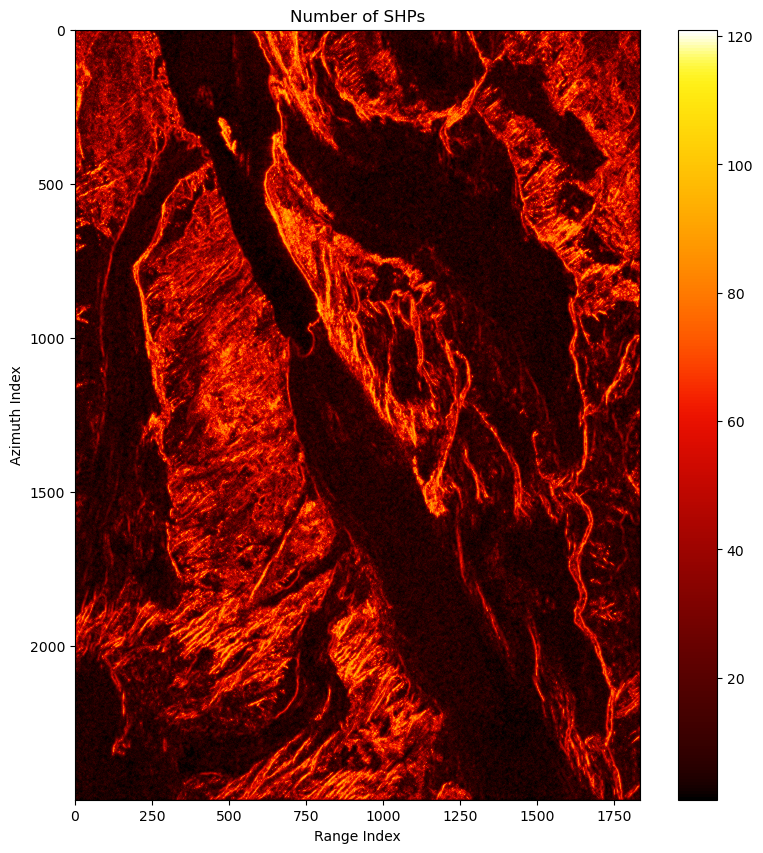

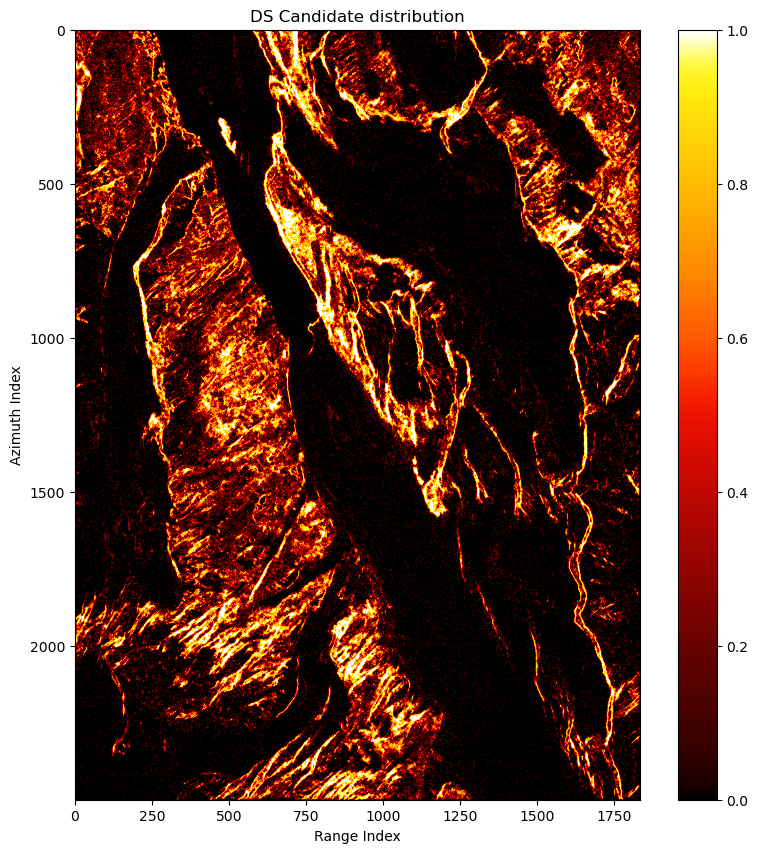

In [ ]:
%%time
#de_select_ds_can(pvalue,is_shp,is_ds_can,ds_can_is_shp,p_max=p_max)
de_select_ds_can(pvalue,is_shp,is_ds_can,ds_can_is_shp,p_max=p_max,r_chunk_size=r_chunk_size,az_chunk_size=az_chunk_size,ds_can_chunk_size=ds_can_chunk_size,shp_num_fig=shp_num_fig,is_ds_can_fig=is_ds_can_fig)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()